# iQuHack 2026 - Quantum Entanglement Distillation Game

In this game, you design quantum circuits to distill noisy Bell pairs and claim edges in a network.

**Game Flow**: Register -> Select Starting Node -> Design Circuits -> Claim Edges -> Score Points

In [ ]:
# !pip install qiskit[visualization]==2.3.0 networkx==3.4.2 requests==2.32.5 ipykernel==7.1.0 matplotlib>=3.7.0


In [1]:
%load_ext autoreload
%autoreload 2
from client import GameClient
from visualization import GraphTool
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import json
from pathlib import Path

## Session Management

Save/load your session to avoid re-registering.

In [2]:
SESSION_FILE = Path("session.json")

def save_session(client):
    if client.api_token:
        with open(SESSION_FILE, "w") as f:
            json.dump({"api_token": client.api_token, "player_id": client.player_id, "name": client.name}, f)
        print(f"Session saved.")

def load_session():
    if not SESSION_FILE.exists():
        return None
    with open(SESSION_FILE) as f:
        data = json.load(f)
    client = GameClient(api_token=data.get("api_token"))
    client.player_id = data.get("player_id")
    client.name = data.get("name")
    status = client.get_status()
    if status:
        print(f"Resumed: {client.player_id} | Score: {status.get('score', 0)} | Budget: {status.get('budget', 0)}")
        return client
    return None

In [496]:
# Try to resume existing session
client = load_session()

if not client:
    print("No saved session. Register below.")

Resumed: to7a2 | Score: 0 | Budget: 40


## Step 1: Register

Skip this if you resumed a session above.

In [497]:
if client and client.api_token:
    print(f"Already registered as {client.player_id}")
else:
    client = GameClient()
    
    # CHANGE THESE to your unique values
    PLAYER_ID = "to7a2"
    PLAYER_NAME = "to7a"
    
    result = client.register(PLAYER_ID, PLAYER_NAME, location=input("remote or in_person: ").strip())
    
    if result.get("ok"):
        print(f"Registered! Token: {client.api_token[:20]}...")
        candidates = result["data"].get("starting_candidates", [])
        print(f"\nStarting candidates ({len(candidates)}):")
        for c in candidates:
            print(f"  - {c['node_id']}: {c['utility_qubits']} qubits, +{c['bonus_bell_pairs']} bonus")
        save_session(client)
    else:
        print(f"Failed: {result.get('error', {}).get('message')}")

Already registered as to7a2


## Step 2: Select Starting Node

In [727]:
status = client.get_status()
print(status)
print(status.get('starting_node'))
if status.get('starting_node'):
    print(f"Starting node: {status['starting_node']}")
    print(f"Budget: {status['budget']} | Score: {status['score']}")
else:
    print("Select a starting node from the candidates shown above.")
    # Uncomment and modify:
    # result = client.select_starting_node("Kharkiv, Ukraine")
    # result = client.select_starting_node("AShenzhen, China")
    # result = client.select_starting_node("Da Nang, Vietnam")
    result = client.select_starting_node("Stockholm, Sweden")


    print(result)

{'player_id': 'to7a2', 'name': 'to7a', 'score': 0, 'budget': 40, 'starting_node': None, 'is_active': True, 'owned_nodes': [], 'owned_edges': []}
None
Select a starting node from the candidates shown above.
{'ok': True, 'data': {'success': True, 'starting_node': 'Stockholm, Sweden', 'score': 101, 'budget': 40}}


## Step 3: Explore the Network

In [728]:
client.print_status()

Player: to7a2 (to7a)
Score: 101 | Budget: 40 bell pairs
Active: Yes
Starting node: Stockholm, Sweden
Owned: 37 nodes, 60 edges
Claimable edges: 53
  - ['London, UK', 'Oxford, UK']: threshold=0.90, difficulty=1
  - ['London, UK', 'Southampton, UK']: threshold=0.90, difficulty=1
  - ['Birmingham, UK', 'London, UK']: threshold=0.90, difficulty=2
  ... and 50 more


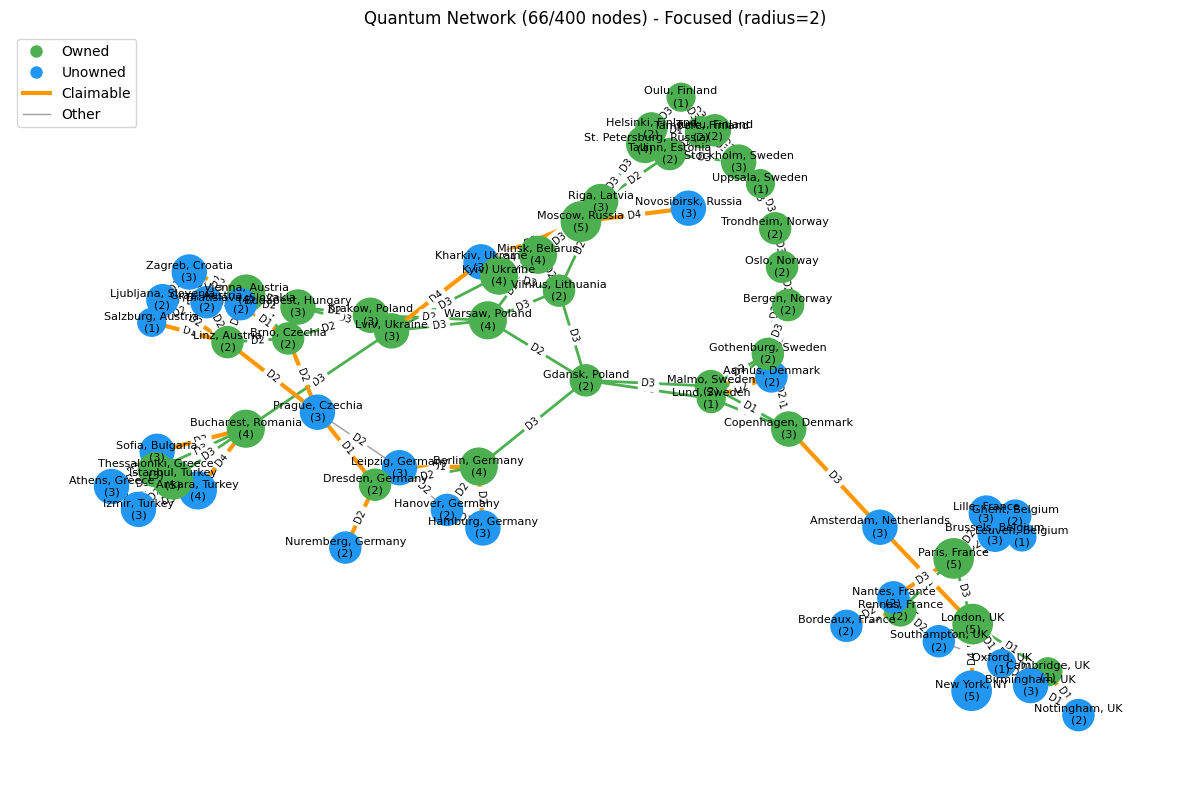

In [729]:
# Visualize the network (focused around your nodes)
viz = GraphTool(client.get_cached_graph())
owned = set(client.get_status().get('owned_nodes', []))
viz.render(owned)

## Step 4: Design a Distillation Circuit

For N Bell pairs, qubits are paired outside-in:
- Pair 0: qubits {0, 2N-1}
- Pair 1: qubits {1, 2N-2}
- ...
- Final pair: qubits {N-1, N}

Design a circuit that improves fidelity through LOCC operations.

In [1154]:
def create_distillation_circuit():
    """
    Simple distillation circuit using OpenQASM 3.0 directly.
    Alice: Keep q[1], Sacrifice q[0]
    Bob: Keep q[2], Sacrifice q[3]
    Flag Logic: Success if measurements match (XOR is 0)
    """
#  diff 1
    qasm_code1 = """
OPENQASM 3.0;
include "stdgates.inc";

bit[3] c;   // c[0]=Alice, c[1]=Bob, c[2]=Flag

qubit[4] q; // q[0]..q[3]

// Alice: Keep q[1], Sacrifice q[0]
cx q[1], q[0]; 

// Bob: Keep q[2], Sacrifice q[3]
cx q[2], q[3]; 

// Measure sacrificial qubits
c[0] = measure q[0];
c[1] = measure q[3];

// Flag Logic: Success if measurements match (XOR is 0)
c[2] = c[0] ^ c[1];
"""

#  diff 2
    qasm_code2 = """
OPENQASM 3.0;
include "stdgates.inc";
bit[3] c;
qubit[4] q;

// MAPPING: Alice(q0, q1), Bob(q2, q3)
// Keepers: q[1], q[2]
// Sacrificial: q[0], q[3]

// 1. ROTATE Y -> Z
// We use S-dagger then Hadamard to map Y to Z.
sdg q[0]; sdg q[1]; sdg q[2]; sdg q[3];
h q[0]; h q[1]; h q[2]; h q[3];

// 2. PURIFY (Parity Check in Z-basis)
cx q[1], q[0]; 
cx q[2], q[3]; 

// 3. MEASURE SACRIFICIAL (Check for errors)
c[0] = measure q[0];
c[1] = measure q[3];

// 4. UN-ROTATE KEEPERS (Z -> Y)
// Hadamard then S maps Z back to Y.
h q[1]; h q[2];
s q[1]; s q[2];

// 5. FLAG LOGIC
c[2] = c[0] ^ c[1];
"""
#  diff 3

    qasm_code3 = """
OPENQASM 3.0;
include "stdgates.inc";
bit[5] c; 
qubit[4] q;

// --- ROUND 1: Z-CHECK (Bit Errors) ---
// No H gates needed for Z-check.
cx q[1], q[0]; 
cx q[2], q[3]; 

// Measure
c[0] = measure q[0];
c[1] = measure q[3];

// Check Parity 1 (Store in c[0])
c[0] = c[0] ^ c[1];

// --- RESET ---
reset q[0];
reset q[3];

// --- ROUND 2: X-CHECK (Phase Errors) ---
// Rotate Keepers (1,2) and Helpers (0,3) to X
h q[1]; h q[2];
h q[0]; h q[3];

// Parity Check
cx q[1], q[0];
cx q[2], q[3];

// Measure
c[2] = measure q[0];
c[3] = measure q[3];

// Check Parity 2 (Store in c[2])
c[2] = c[2] ^ c[3];

// --- RESTORE KEEPERS ---
// Important! We must put the keepers back to Z-basis
h q[1]; 
h q[2];


if (c[2] == 1) c[0] = 1;
"""
    return qasm_code2.strip()


circuit = create_distillation_circuit()
print("OpenQASM 3.0 Circuit:")
print(circuit)
print("\n" + "="*50)

OpenQASM 3.0 Circuit:
OPENQASM 3.0;
include "stdgates.inc";
bit[3] c;
qubit[4] q;

// MAPPING: Alice(q0, q1), Bob(q2, q3)
// Keepers: q[1], q[2]
// Sacrificial: q[0], q[3]

// 1. ROTATE Y -> Z
// We use S-dagger then Hadamard to map Y to Z.
sdg q[0]; sdg q[1]; sdg q[2]; sdg q[3];
h q[0]; h q[1]; h q[2]; h q[3];

// 2. PURIFY (Parity Check in Z-basis)
cx q[1], q[0]; 
cx q[2], q[3]; 

// 3. MEASURE SACRIFICIAL (Check for errors)
c[0] = measure q[0];
c[1] = measure q[3];

// 4. UN-ROTATE KEEPERS (Z -> Y)
// Hadamard then S maps Z back to Y.
h q[1]; h q[2];
s q[1]; s q[2];

// 5. FLAG LOGIC
c[2] = c[0] ^ c[1];



## Step 5: Claim an Edge

In [1155]:
# Find claimable edges
claimable = client.get_claimable_edges()
claimable_sorted = sorted(claimable, key=lambda e: (e['difficulty_rating'], e['base_threshold']))

print(f"Claimable edges ({len(claimable)}):")
for edge in claimable_sorted[:61]:
    print(f"  {edge['edge_id']} - threshold: {edge['base_threshold']:.3f}, difficulty: {edge['difficulty_rating']}")

Claimable edges (60):
  ['Birmingham, UK', 'Oxford, UK'] - threshold: 0.900, difficulty: 1
  ['Oxford, UK', 'Southampton, UK'] - threshold: 0.900, difficulty: 1
  ['Bristol, UK', 'Oxford, UK'] - threshold: 0.900, difficulty: 1
  ['London, UK', 'Southampton, UK'] - threshold: 0.900, difficulty: 1
  ['Berlin, Germany', 'Leipzig, Germany'] - threshold: 0.900, difficulty: 1
  ['Bremen, Germany', 'Hamburg, Germany'] - threshold: 0.900, difficulty: 1
  ['Hamburg, Germany', 'Hanover, Germany'] - threshold: 0.900, difficulty: 1
  ['Amsterdam, Netherlands', 'Utrecht, Netherlands'] - threshold: 0.900, difficulty: 1
  ['Amsterdam, Netherlands', 'Leiden, Netherlands'] - threshold: 0.900, difficulty: 1
  ['Amsterdam, Netherlands', 'Delft, Netherlands'] - threshold: 0.900, difficulty: 1
  ['Delft, Netherlands', 'Rotterdam, Netherlands'] - threshold: 0.900, difficulty: 1
  ['Leiden, Netherlands', 'Rotterdam, Netherlands'] - threshold: 0.900, difficulty: 1
  ['Rotterdam, Netherlands', 'Utrecht, Nether

In [1156]:

if claimable:
    target = claimable_sorted[57] # Easiest edge
    edge_id = tuple(target['edge_id'])
    
    circuit = create_distillation_circuit()
    num_bell_pairs = 2
    flag_bit = 2 # Classical bit for post-selection (keep when flag=0)
    
    print(f"Claiming {edge_id} (threshold: {target['base_threshold']:.3f})...")
    
    result = client.claim_edge(edge_id, circuit, flag_bit, num_bell_pairs)
    
    if result.get("ok"):
        data = result["data"]
        print(f"Success: {data.get('success')}")
        print(f"Fidelity: {data.get('fidelity', 0):.4f} (threshold: {data.get('threshold', 0):.4f})")
        print(f"Success probability: {data.get('success_probability', 0):.4f}")
    else:
        print(f"Error: {result.get('error', {}).get('message')}")

Claiming ('Moscow, Russia', 'Novosibirsk, Russia') (threshold: 0.920)...
Success: False
Fidelity: 0.8686 (threshold: 0.9200)
Success probability: 0.5968


## Step 6: Check Progress

In [1024]:
client.print_status()

Player: to7a2 (to7a)
Score: 123 | Budget: 4 bell pairs
Active: Yes
Starting node: Stockholm, Sweden
Owned: 45 nodes, 73 edges
Claimable edges: 60
  - ['Birmingham, UK', 'Oxford, UK']: threshold=0.90, difficulty=1
  - ['Oxford, UK', 'Southampton, UK']: threshold=0.90, difficulty=1
  - ['Bristol, UK', 'Oxford, UK']: threshold=0.90, difficulty=1
  ... and 57 more


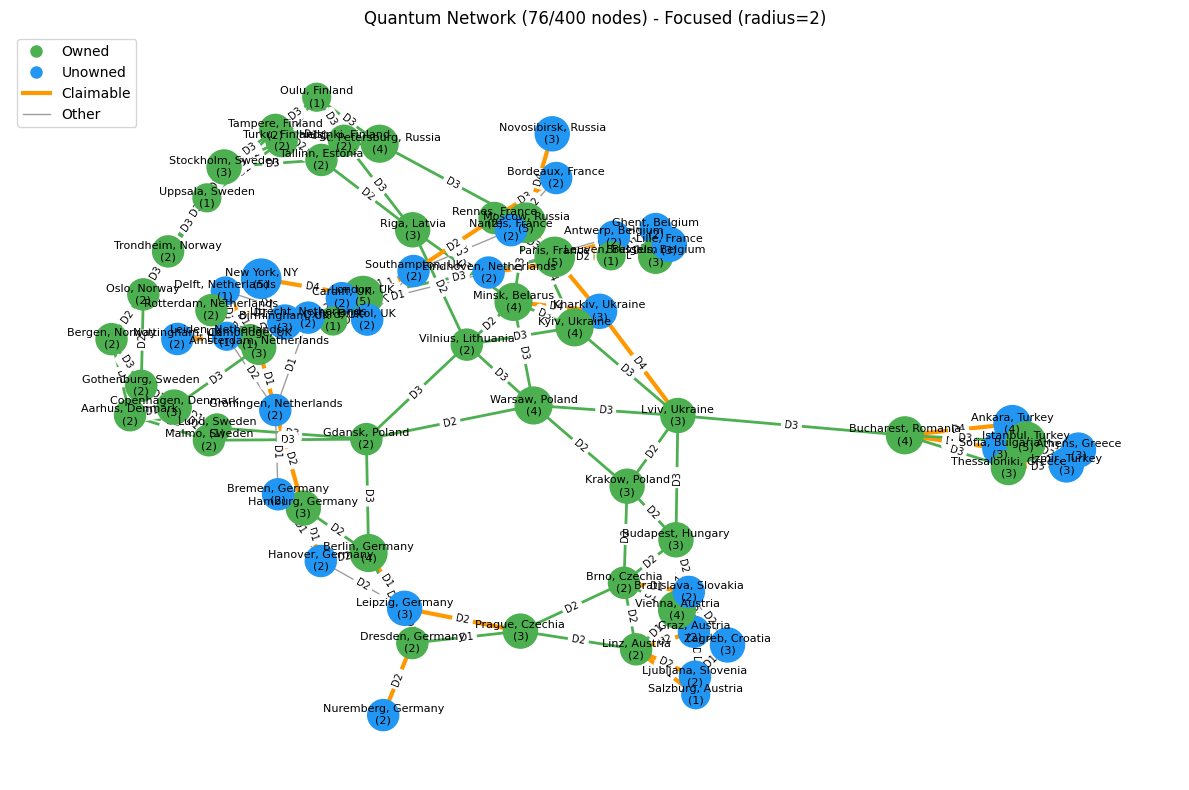

In [1023]:
# Visualize the network (focused around your nodes)
viz = GraphTool(client.get_cached_graph())
owned = set(client.get_status().get('owned_nodes', []))
viz.render(owned)

In [987]:
# View leaderboard
leaderboard = client.get_leaderboard()["leaderboard"]
print("Leaderboard:")
for i, p in enumerate(leaderboard[:10]):
    print(f"{i+1}. {p.get('player_id', 'Unknown'):20} Score: {p.get('score', 0)}")

Leaderboard:
1. to7a2                Score: 119
2. GiselleRocio         Score: 104
3. Julio Cesar          Score: 99
4. 121234382            Score: 87
5. diyamagnetism28      Score: 85
6. bloch                Score: 84
7. bloch_distiller      Score: 84
8. bloch_single_run_v8  Score: 73
9. test_claude_1523b    Score: 69
10. orion_the_first      Score: 69


## Tips

- **Failed attempts are free** - only successful claims cost bell pairs
- **More bell pairs** can improve fidelity but cost more budget
- **Vertex rewards** are competitive - top players by claim strength earn rewards
- **Budget management** is key - if budget reaches 0, you're eliminated

Good luck!

In [726]:
# # Restart game (uncomment to use)
result = client.restart()
print(result)

{'ok': True, 'data': {'success': True, 'budget': 40, 'is_active': True, 'starting_candidates': [{'node_id': 'Kharkiv, Ukraine', 'utility_qubits': 3, 'bonus_bell_pairs': 0, 'capacity': 5, 'latitude': 49.9935, 'longitude': 36.2304}, {'node_id': 'Shenzhen, China', 'utility_qubits': 5, 'bonus_bell_pairs': 0, 'capacity': 10, 'latitude': 22.5431, 'longitude': 114.0579}, {'node_id': 'Da Nang, Vietnam', 'utility_qubits': 3, 'bonus_bell_pairs': 0, 'capacity': 5, 'latitude': 16.0544, 'longitude': 108.2022}, {'node_id': 'Stockholm, Sweden', 'utility_qubits': 3, 'bonus_bell_pairs': 1, 'capacity': 8, 'latitude': 59.3293, 'longitude': 18.0686}]}}
